# Plot the a0 input files



In [41]:
import xarray as xr
import matplotlib.pyplot as plt
import h5py 
import numpy as np

from sfoda.utils.timeseries import skill, rmse

In [38]:
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 'medium'

In [3]:
def load_beta_h5(betafile):
    # Get the time from the beta file
    with h5py.File(betafile,'r') as f:
        t_beta=f['data/time'][:].astype('<M8[ns]')
        beta_samples = f['beta_samples'][:]
        z_std = np.array(f['data/z_std'])
        rho_std = np.array(f['data/rho_std'])
        rho_mu = np.array(f['data/rho_mu'])

    nparams, nt, nsamples = beta_samples.shape
    return xr.DataArray(beta_samples, dims=('params','time','draw'), 
                 coords={'time':t_beta,'params':range(nparams), 'draw':range(nsamples)})

In [4]:
!ls -lah ../inputs/a0_samples_harmonic*.nc

-rw-r--r-- 1 jupyter-ubuntu jupyter-ubuntu  30M Mar 31  2021 ../inputs/a0_samples_harmonicfit_M2S2N2K1O1P1_na0_AR1_dt20min_12month.nc
-rw-r--r-- 1 jupyter-ubuntu jupyter-ubuntu  30M Mar 31  2021 ../inputs/a0_samples_harmonicfit_M2S2N2K1O1P1_na0_AR4_dt20min_12month.nc
-rw-r--r-- 1 jupyter-ubuntu jupyter-ubuntu 181M Mar 31  2021 ../inputs/a0_samples_harmonicfit_M2S2N2K1O1P1_na0_dt20min_12month.nc
-rw-r--r-- 1 jupyter-ubuntu jupyter-ubuntu  30M Mar 31  2021 ../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na0_AR1_12month.nc
-rw-r--r-- 1 jupyter-ubuntu jupyter-ubuntu  30M Mar 31  2021 ../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na0_AR2_12month.nc
-rw-r--r-- 1 jupyter-ubuntu jupyter-ubuntu  30M Mar 31  2021 ../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na0_AR3_12month.nc
-rw-r--r-- 1 jupyter-ubuntu jupyter-ubuntu  30M Mar 31  2021 ../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na0_AR4_12month.nc
-rw-r--r-- 1 jupyter-ubuntu jupyter-ubuntu  30M Mar 31  2021 ../inputs/a0_samples_harmonicfit_M2S2N2K1O1_n

In [5]:

###
# a0 files


# Seasonal harmonics model
a0file_ar = '../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na3_dt60min_12month.nc'

# Deterministic harmonics only
# a0file = '../inputs/a0_samples_harmonicfit_M2S2N2K1O1P1_na0_dt20min_12month.nc'
a0file = '../inputs/a0_samples_harmonicfit_M2S2N2K1O1_na0_dt60min_12month.nc'

###
# beta (rho) files
outdir = '../inputs'
betafile = '%s/ShellCrux_Filtered_Density_Harmonic_MCMC_20162017_v5.h5'%outdir
betafile_mu = '%s/ShellCrux_Filtered_Density_Harmonic_MCMC_20162017_prediction_v5.h5'%outdir


In [6]:
a0_obs_ds = xr.open_dataset(a0file, group='observed_data')
a0_obs_ds

<xarray.Dataset>
Dimensions:      (X_obs_dim_0: 8952, time: 8952)
Coordinates:
  * X_obs_dim_0  (X_obs_dim_0) int64 0 1 2 3 4 5 ... 8947 8948 8949 8950 8951
  * time         (time) datetime64[ns] 2016-04-29T23:15:00 ... 2017-05-08T01:...
Data variables:
    X_obs        (time) float64 ...
Attributes:
    created_at:                 2021-05-10T07:24:54.932569
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2

In [7]:
# Load a0 and plot

a0_ds = xr.open_dataset(a0file, group='predictions')
a0_ar_ds = xr.open_dataset(a0file_ar, group='predictions')

In [8]:
beta_ds = load_beta_h5(betafile)
beta_mu_ds = load_beta_h5(betafile_mu)


In [9]:
a0_ds

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 500, time: 8785)
Coordinates:
  * chain    (chain) int64 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * time     (time) datetime64[ns] 2016-05-01 2016-05-01T01:00:00 ... 2017-05-02
Data variables:
    a0       (chain, draw, time) float64 ...
Attributes:
    created_at:                 2021-05-10T07:24:54.489823
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2

In [10]:
def get_credint(a0):
    a_low = np.percentile(a0['a0'][0,:,:],5, axis=0)
    a_high = np.percentile(a0['a0'][0,:,:],95, axis=0)
    return a_low, a_high

In [64]:
Xobs = a0_obs_ds['X_obs'].sel(time=a0_ds.time, method='nearest').values

resid_tidal = Xobs-a0_ds['a0'].values
resid_seasonal = Xobs-a0_ar_ds['a0'].values

print('Skill Tidal: ',skill(a0_ds['a0'][0,:,:].mean(axis=0).values, Xobs) )
print('Skill Seasonal: ',skill(a0_ar_ds['a0'][0,:,:].mean(axis=0).values, Xobs) )
print('std residual tidal: ', np.std(resid_tidal),rmse(a0_ds['a0'][0,:,:].mean(axis=0).values, Xobs))
print('std residual seasonal: ', np.std(resid_seasonal),rmse(a0_ar_ds['a0'][0,:,:].mean(axis=0).values, Xobs))


Skill Tidal:  0.5792115378749123
Skill Seasonal:  0.7350448550011722
std residual tidal:  7.966775571166257 7.962155828088724
std residual seasonal:  6.347652692302828 6.318077371729537


6.318077371729537

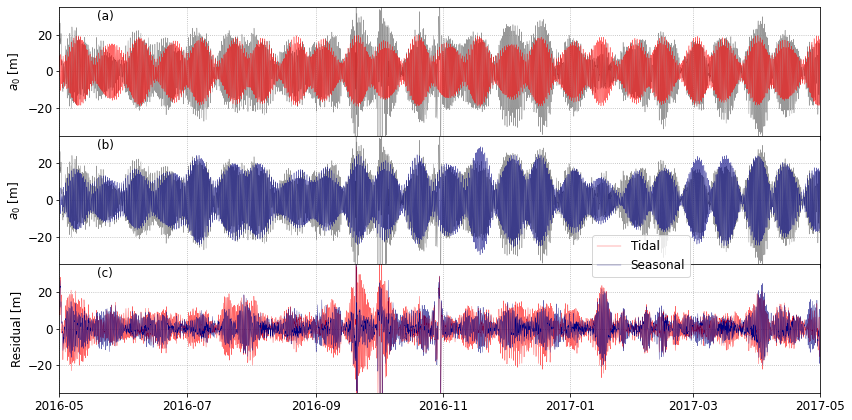

In [66]:
t1,t2 = np.datetime64('2016-05-01'),np.datetime64('2017-05-01')
# t1,t2 = np.datetime64('2016-05-01'),np.datetime64('2016-07-01')

plt.figure(figsize=(12,6))
ax1=plt.subplot(311)
# a_low, a_high = get_credint(a0_ds)
# plt.fill_between(a0_ds.time, a_low, a_high, alpha=0.5)
plt.xlim(t1,t2)
plt.ylim(-35,35)
a0_obs_ds['X_obs'].plot(color='0.5',lw=0.4)
plt.plot(a0_ds.time, a0_ds['a0'][0,:,:].mean(axis=0), lw=0.3, color='r')

ax1.set_xticklabels([])
ax1.set_xlabel('')
plt.ylabel('$a_0$ [m]')
plt.grid(b=True,ls=':')
plt.text(0.05,0.9, '(a)', transform=ax1.transAxes)

# Sesaonal model
ax2=plt.subplot(312)
# a_low, a_high = get_credint(a0_ar_ds)
# plt.fill_between(a0_ar_ds.time, a_low, a_high, alpha=0.5)
plt.xlim(t1,t2)
plt.ylim(-35,35)
a0_obs_ds['X_obs'].plot(color='0.5',lw=0.4)
plt.plot(a0_ar_ds.time, a0_ar_ds['a0'][0,:,:].mean(axis=0), lw=0.3,color='navy')

ax2.set_xticklabels([])
ax2.set_xlabel('')
plt.ylabel('$a_0$ [m]')
plt.grid(b=True,ls=':')
plt.text(0.05,0.9, '(b)', transform=ax2.transAxes)


# Resduals
ax1a=plt.subplot(313)
plt.plot(a0_ds.time, resid_tidal[0,:,:].mean(axis=0), lw=0.3, color='r')
plt.plot(a0_ds.time, resid_seasonal[0,:,:].mean(axis=0), lw=0.3, color='navy')

plt.ylim(-35,35)
plt.xlim(t1,t2)
plt.ylabel('Residual [m]')
plt.legend(('Tidal','Seasonal'),loc=(0.7,0.9))
plt.grid(b=True,ls=':')
plt.text(0.05,0.9, '(c)', transform=ax1a.transAxes)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('../FIGURES/a0_posterior_residual.png',dpi=150)
plt.savefig('../FIGURES/a0_posterior_residual.pdf',dpi=150)

*Figure XX: 12-months of tidal band-passed filtered mode-1 amplitude derived from the KP150 thermistor string (gray) with (a)the mean posterior from the tidal harmonic model, and (b) the seasonal harmonic model. (c) The mean residual term from each of the harmonic models.
*
The 

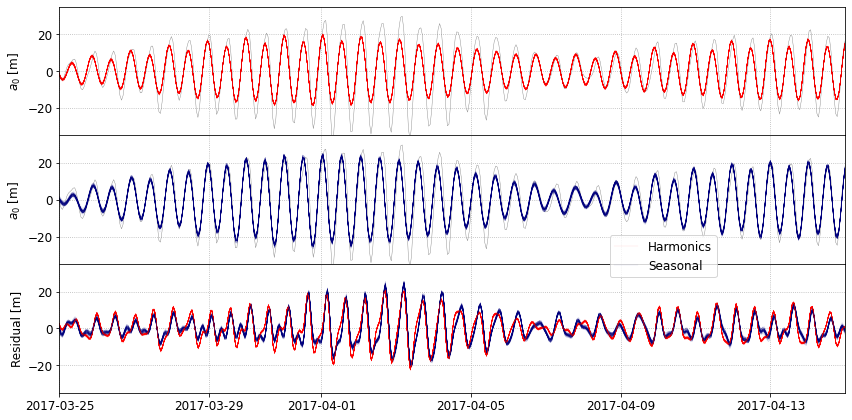

In [57]:
# t1,t2 = np.datetime64('2016-05-01'),np.datetime64('2017-05-01')
t1,t2 = np.datetime64('2017-03-25'),np.datetime64('2017-04-15')

plt.figure(figsize=(12,6))
ax1=plt.subplot(311)
# a_low, a_high = get_credint(a0_ds)
# plt.fill_between(a0_ds.time, a_low, a_high, alpha=0.5)
plt.xlim(t1,t2)
plt.ylim(-35,35)
a0_obs_ds['X_obs'].plot(color='0.5',lw=0.4)

for ii in np.random.randint(500, size=(100)):
    plt.plot(a0_ds.time, a0_ds['a0'][0,ii,:], lw=0.3, color='r', alpha=0.2)

ax1.set_xticklabels([])
ax1.set_xlabel('')
plt.ylabel('$a_0$ [m]')
plt.grid(b=True,ls=':')

# Sesaonal model
ax2=plt.subplot(312)
# a_low, a_high = get_credint(a0_ar_ds)
# plt.fill_between(a0_ar_ds.time, a_low, a_high, alpha=0.5)
plt.xlim(t1,t2)
plt.ylim(-35,35)
a0_obs_ds['X_obs'].plot(color='0.5',lw=0.4)

for ii in np.random.randint(500, size=(100)):
    plt.plot(a0_ar_ds.time, a0_ar_ds['a0'][0,ii,:], lw=0.3,color='navy', alpha=0.2)

ax2.set_xticklabels([])
ax2.set_xlabel('')
plt.ylabel('$a_0$ [m]')
plt.grid(b=True,ls=':')

# Resduals
ax1a=plt.subplot(313)
for ii in np.random.randint(500, size=(100)):
    plt.plot(a0_ds.time, resid_tidal[0,ii,:], lw=0.3, color='r', alpha=0.2)
    plt.plot(a0_ds.time, resid_seasonal[0,ii,:], lw=0.3, color='navy', alpha=0.2)

plt.ylim(-35,35)
plt.xlim(t1,t2)
plt.ylabel('Residual [m]')
plt.legend(('Harmonics','Seasonal'),loc=(0.7,0.9))

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.grid(b=True,ls=':')


In [53]:
a0_ar_ds['a0'].shape

(1, 500, 8785)